# U-net

In [1]:

from PIL import Image
import torch
from tensorboard.summary.v1 import image
from torch import Tensor, nn
from torchvision import io
import numpy as np
from torchvision.transforms import functional
import os


## 一， utils

In [2]:


def keep_image_size(path: str, size=(256, 256)) -> Image.Image:
    img = Image.open(path)
    max_size=max(img.size)
    mask = Image.new('RGB', (max_size, max_size), (0, 0, 0))
    mask.paste(img, (0, 0))
    mask = mask.resize(size)
    return mask

def keep_mask_image_size(path: str, size=(256, 256)) -> Image.Image:
    img = Image.open(path).convert("L")
    max_size=max(img.size)
    mask = Image.new('L', (max_size, max_size), 0)
    mask.paste(img, (0, 0))
    mask = mask.resize(size)
    return mask

def pad_16(image: Tensor) -> Tensor:
    width,height= functional.get_image_size(image)
    pad_height = (16 - height % 16) % 16
    pad_width = (16 - width % 16) % 16
    # 表示在左、右,上、下、四个方向 mode：指定填充模式，可以是 “constant”、“reflect” 或 “replicate”；
    pad_image = nn.functional.pad(image, (0, pad_width , 0, pad_height), mode='reflect')
    return pad_image

def show_image_memory_size(path: str):
    img = io.read_image(path)
    print(f"img shape:{img.shape}")
    print(f"data type:{img.dtype}")

    total_bytes = img.shape[0] * img.shape[1] * img.shape[2] * img.dtype.itemsize
    print(f"total bytes:{total_bytes},MB:{total_bytes/(1024*1024)}")



## 二， 定义模型

In [3]:


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.layer(x)


class DownSimple(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.layer(x)


class UpSimple(nn.Module):
    def __init__(self, in_channels,out_channels):
        super().__init__()
        # 上采样 channel 减半
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        # 卷积 channel 减半
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, up_x, cat_left_x):
        upx = self.up(up_x)
        # 注意 链接时左右
        x = torch.cat((cat_left_x, upx), dim=1)
        return self.double_conv(x)


class Unet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.input = DoubleConv(in_channel, 64)

        self.down1 = DownSimple(64, 128)
        self.down2 = DownSimple(128, 256)
        self.down3 = DownSimple(256, 512)
        self.down4 = DownSimple(512, 1024)

        self.up4 = UpSimple(1024,512)
        self.up3 = UpSimple(512,256)
        self.up2 = UpSimple(256,128)
        self.up1 = UpSimple(128,64)

        self.output = nn.Conv2d(64, out_channel, kernel_size=1)

    def forward(self, x):
        x1 = self.input(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        up4 = self.up4(x5,x4)
        up3 = self.up3(up4,x3)
        up2 = self.up2(up3,x2)
        up1 = self.up1(up2,x1)
        output= self.output(up1)

        return torch.sigmoid(output)

## 三，dataset

In [4]:
import os
import torch
from functorch.dim import Tensor
from torch.utils.data import Dataset
from torchvision import transforms
import shutil


transform = transforms.Compose([
    transforms.ToTensor()
])

# 路径，和最大 图片像素
class WaterDataset(Dataset):
    def __init__(self, path,max_size=2000_000):
        super().__init__()
        self.path = path
        self.mask_path_list = []
        self.image_path_list = []
        self.max_size=max_size

        self.mask_path = os.path.join(path, 'Annotations')
        self.image_path = os.path.join(path, 'JPEGImages')

        for dir_name, _, file_names in os.walk(self.mask_path):
            for file_name in file_names:
                mask_path = os.path.join(dir_name, file_name)
                image_path_jpg = mask_path.replace("Annotations", "JPEGImages").replace(".png", ".jpg")
                image_path_png = mask_path.replace("Annotations", "JPEGImages")

                if os.path.exists(image_path_jpg):
                    self.image_path_list.append(image_path_jpg)
                    self.mask_path_list.append(mask_path)
                elif os.path.exists(image_path_png):
                    self.image_path_list.append(image_path_png)
                    self.mask_path_list.append(mask_path)
                else:
                    print(f"找不到图片： {image_path_png}  ｛image_path_jpg｝")

    def __len__(self):
        return len(self.mask_path_list)

    def __getitem__(self, index) -> tuple[Tensor, Tensor]:
        image_path = self.image_path_list[index]
        image_mask_path = self.mask_path_list[index]

        try:
            image = Image.open(image_path).convert("RGB")
            mask_image = Image.open(image_mask_path).convert("L")

            # 图片太大，进行等比列缩放-内存不足

            width, height = image.size
            pixel_num = width * height
            if pixel_num > self.max_size:
                scale_factor = self.max_size / pixel_num
                new_width = int(width * scale_factor)
                new_height = int(height * scale_factor)
                # 缩放图像,建议双线性插值
                image = image.resize((new_width, new_height), resample=Image.LANCZOS)
                mask_image = mask_image.resize((new_width, new_height), resample=Image.LANCZOS)

            image = transform(image)
            mask_image = transform(mask_image)

            return pad_16(image), pad_16(mask_image)
        except Exception as e:
            print(f"数据错误: {image_path}", e)
            return torch.randn(0, 1, 1, 1), torch.randn(0, 1, 1, 1)


transform512 = transforms.Compose([
    transforms.Resize(512),  # 保持长宽比，调整最短边为512像素
    transforms.CenterCrop(512),  # 从中心裁剪512x512的图片
    transforms.ToTensor()  # 转换成Tensor，方便后续处理
])


class WaterDataset512(Dataset):
    def __init__(self, path):
        super().__init__()
        self.path = path
        self.mask_path_list = []
        self.image_path_list = []

        self.mask_path = os.path.join(path, 'Annotations')
        self.image_path = os.path.join(path, 'JPEGImages')

        for dir_name, _, file_names in os.walk(self.mask_path):
            for file_name in file_names:
                mask_path = os.path.join(dir_name, file_name)
                image_path_jpg = mask_path.replace("Annotations", "JPEGImages").replace(".png", ".jpg")
                image_path_png = mask_path.replace("Annotations", "JPEGImages")

                if os.path.exists(image_path_jpg):
                    self.image_path_list.append(image_path_jpg)
                    self.mask_path_list.append(mask_path)
                elif os.path.exists(image_path_png):
                    self.image_path_list.append(image_path_png)
                    self.mask_path_list.append(mask_path)
                else:
                    print(f"找不到图片： {image_path_png}  ｛image_path_jpg｝")

    def __len__(self):
        return len(self.mask_path_list)

    def __getitem__(self, index) -> tuple[Tensor, Tensor]:
        image_path = self.image_path_list[index]
        image_mask_path = self.mask_path_list[index]

        try:
            image = Image.open(image_path).convert("RGB")
            mask_image = Image.open(image_mask_path).convert("L")

            image = transform512(image)
            mask_image = transform512(mask_image)

            return image, mask_image
        except  Exception as e:
            print(f"数据错误: {image_path},{e}")
            return torch.randn(0, 1, 1, 1), torch.randn(0, 1, 1, 1)


## 四，训练

2024-09-13 14:36:23,628 - train - INFO - 训练数据: 6360  测试训练数据: 706 
2024-09-13 14:36:23,628 - train - INFO - 训练数据: 6360  测试训练数据: 706 


找不到图片： E:\语义分割\water_v2\water_v2\JPEGImages\stream2\12_00.json  ｛image_path_jpg｝
找不到图片： E:\语义分割\water_v2\water_v2\JPEGImages\stream2\12_00_json\img.png  ｛image_path_jpg｝
找不到图片： E:\语义分割\water_v2\water_v2\JPEGImages\stream2\12_00_json\info.yaml  ｛image_path_jpg｝
找不到图片： E:\语义分割\water_v2\water_v2\JPEGImages\stream2\12_00_json\label.png  ｛image_path_jpg｝
找不到图片： E:\语义分割\water_v2\water_v2\JPEGImages\stream2\12_00_json\label_names.txt  ｛image_path_jpg｝
找不到图片： E:\语义分割\water_v2\water_v2\JPEGImages\stream2\12_00_json\label_viz.png  ｛image_path_jpg｝


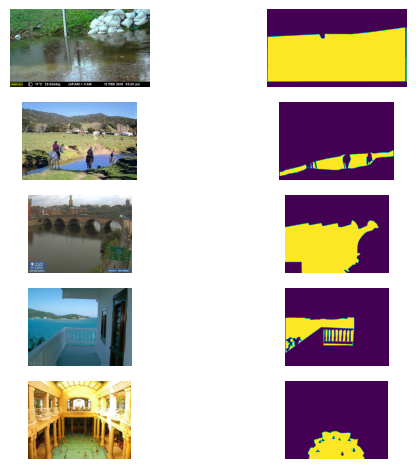

2024-09-13 14:36:28,797 - train - INFO - epoch:0 step: 0,loss: 0.6843527555465698 iou:0.0021061235666275024
2024-09-13 14:36:28,797 - train - INFO - epoch:0 step: 0,loss: 0.6843527555465698 iou:0.0021061235666275024


KeyboardInterrupt: 

In [6]:
import torch
from torch.optim import *
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.transforms import functional, transforms,ToPILImage
import logging
from torchmetrics.segmentation import MeanIoU



# 训练停止条件，连续 多少次没有增长
class TrainStop:
    def __init__(self, count=3):
        self.count = count
        self.score_list = [0.0]
        self.best = 0.0
        self.trigger_count = 0

    def __call__(self, score: float) -> bool:
        self.score_list.append(score)
        total = sum(self.score_list[-self.count:])
        # 最佳分数： 最后几次平均分
        mean=total / self.count
        if  mean > self.best:
            self.best = mean

        # 分数没有超过之前，已经 count 次，就停止
        if self.best > score:
            self.trigger_count += 1
            if self.trigger_count > self.count+1:
                return True

        return False
# 日志
def config_logger(name="train"):
    # 设置日志的基本配置
    logger = logging.getLogger("train")
    logger.setLevel(logging.DEBUG)
    # 创建一个handler，用于写入日志文件
    file_handler = logging.FileHandler('app.log')
    file_handler.setLevel(logging.DEBUG)
    # 再创建一个handler，用于输出到控制台
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.DEBUG)
    # 定义handler的输出格式
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    stream_handler.setFormatter(formatter)
    # 给logger添加handler
    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)
    return logger


# 合并datasets
def merge_datasets(dataset_list):
    image_path_list = []
    mask_path_list = []
    for dataset in dataset_list:
        image_path_list = image_path_list + dataset.image_path_list
        mask_path_list = mask_path_list + dataset.mask_path_list

    new_dataset = WaterDataset(dataset_list[0].path)
    new_dataset.image_path_list = image_path_list
    new_dataset.mask_path_list = mask_path_list

    return new_dataset

def show_images(dataloader,num=3):
    to_pil_image = ToPILImage()
    plt.figure()
    for i in range(1,num*2,2):
       
       imgs,masks=  dataloader.dataset[i]

       plt.subplot(num, 2,i)
       plt.imshow(to_pil_image(imgs))
       plt.axis('off')

       plt.subplot(num, 2, i+1)
       plt.imshow(to_pil_image(masks))
       plt.axis('off')

    plt.tight_layout()
    plt.show()



logger = config_logger()
train_stop = TrainStop(count=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset1 = WaterDataset(f"E:\语义分割\water_v1\water_v1")
dataset2 = WaterDataset(f"E:\语义分割\water_v2\water_v2")
dataset3 = WaterDataset(f"D:\语义分割\水体标注\project-2-at-2024-09-06-17-48-376b4f93")
dataset4 = WaterDataset(f"D:\语义分割\water_v2")
dataset = merge_datasets([dataset1, dataset2,dataset3])

# 把数据拆分为 9：1 
# 每次都生成一样
generator = torch.Generator().manual_seed(666)
total_length = len(dataset)
var_length = int(total_length * 0.1)
train_dataset, val_dataset = random_split(dataset, [total_length - var_length, var_length],generator=generator)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=1)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1)

logger.info(f"训练数据: {len(train_dataloader)}  测试训练数据: {len(val_dataloader)} ")

show_images(val_dataloader,5)


model = Unet(3, 1).to(device)
loss = nn.BCELoss().to(device)
optimizer = Adam(model.parameters(), 0.001)
mean_iou = MeanIoU(num_classes=2).to(device)

for epoch in range(20):
    # 训练
    model.train()
    total_loss = 0
    mean_iou.reset()
    
    for step, (images, mask_images) in enumerate(train_dataloader):
        # todo 返回 None,或者 这句话写到下面 -会还是对图片进行 采集，会出现一个问题
        images, mask_images = images.to(device), mask_images.to(device)
        height, width = functional.get_image_size(images)

        if images.shape[1] > 3:
            continue
        if mask_images.shape[1] > 1:
            continue
        if images.shape[2] == 1:
            continue

        model_result = model(images)

        loss_result = loss(model_result, mask_images)

        optimizer.zero_grad()
        loss_result.backward()
        optimizer.step()

        # 指标
        total_loss += loss_result.item()
        mean_iou.update((model_result > 0.5).long(), mask_images.long())

        if step % 50 == 0:
            logger.info(f"epoch:{epoch} step: {step},loss: {loss_result.item()} iou:{mean_iou.compute().item() / 50}")
            mean_iou.reset()

    # 验证
    model.eval()
    var_mean_iou = 0
    mean_iou.reset()
    with torch.no_grad():
        for images, targets in val_dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            # 阈值化并转换为整数类型
            outputs = (outputs > 0.5).long()
            # 更新 MeanIoU- 内部是累加
            mean_iou.update(outputs, targets.long())

        logger.info("---" * 20)
        var_mean_iou = mean_iou.compute().item() / len(val_dataloader)
        logger.info(f"第epoch: {epoch}  Var Mean IoU: {var_mean_iou} total_loss :{total_loss}")
       
  
    # 保存模型
    torch.save(model, f"unet-{epoch}.pth")
    logger.info(f"模型已经保存：unet-{epoch}.pth")

    # 是否停止
    is_stop = train_stop(var_mean_iou)
    if is_stop:
        logger.info(f"停止训练: epoch:{epoch} 最佳iou {train_stop.best} , score_list:{train_stop.score_list}")
        break
